# Classifieur bayésien

In [99]:
import pandas as pa
import numpy as np

dataset = pa.read_csv("https://www.labri.fr/perso/zemmari/datasets/salmon_seabass.csv", sep=";")
df = pa.DataFrame(dataset)

df.head()

,lightness,width,species
0,9.710457,8.673699,0
1,6.528089,7.330887,0
2,1.770695,7.599677,0
3,4.819293,7.328198,0
4,6.769638,8.575629,0


In [100]:
# class = data type
# col `species` is class
# 0 : il s'agit d'un saumon
# 1 : il s'agit d'un bar

sizeVTSaumon = np.count_nonzero(df["species"] == 0)
sizeVTBar = np.count_nonzero(df["species"] == 1)

print("Saumon :", sizeVTSaumon, "Bar :", sizeVTBar)

Saumon : 1000 Bar : 500


## Exercice 1

In [101]:
data = df.sample(frac=1)

In [102]:
X = data["width"]
Y = data["species"]

In [103]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
print(len(X_train), str(len(X_train) * 100 / len(X)) + "%")
print(len(X_test), str(len(X_test) * 100 / len(X)) + "%")

1200 80.0%
300 20.0%


### Classifieur ML

In [104]:
# mean is average in statistics (la moyenne)
meanSaumon = np.mean(X_train[Y_train == 0])
meanBar = np.mean(X_train[Y_train == 1])

# l'écart type = standard deviation, the variance : a measure of the spread of a distribution, of the array elements.
stdSaumon = np.std(X_train[Y_train == 0], 0)
stdBar = np.std(X_train[Y_train == 1], 0)
print(meanSaumon, meanBar, stdSaumon, stdBar)

8.041057386916933 12.002973715792866 1.0056113764690169 2.062825255218612


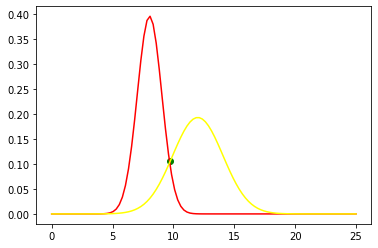

In [105]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as ss
norm = ss.norm # normal low package

x = np.linspace(0, 25, 100)

yn = norm.pdf(x, meanSaumon, stdSaumon)
plt.plot(x, yn, c="red")

yn = norm.pdf(x, meanBar, stdBar)
plt.plot(x, yn, c="yellow")

plt.scatter(9.75, norm.pdf(9.75, meanBar, stdBar), c="green")

- La frontière de décision est 9.75

In [106]:
width = 12
if norm.pdf(width, meanSaumon, stdSaumon) > norm.pdf(width, meanBar, stdBar) :
  print("Saumon")
else:
  print("Bar")

Bar


- Un poisson de longueur 12 est un bar

In [107]:
from sklearn.metrics import confusion_matrix

Y_pred = [norm.pdf(x, meanSaumon, stdSaumon) < norm.pdf(x, meanBar, stdBar) for x in X_test]

cm = confusion_matrix(Y_test, Y_pred)
print(cm)
acc = np.sum(np.diag(cm))/np.sum(cm)

print("{:.2%}".format(acc))

[[195   9]
 [  8  88]]
94.33%


### Classifieur MAP

la vraisemblance de l c'est $\mathbb{P}(l| saumon)$

la probabilités a posteriori (map) = le plus grand entre $\mathbb{P}(saumon|l)=\frac{\mathbb{P}(l| saumon) \cdot\mathbb{P}(saumon)}{\mathbb{P}(l)}$ et $\frac{\mathbb{P}(l|bar) \cdot\mathbb{P}(bar)}{\mathbb{P}(l)}$ donc le plus grand entre $\mathbb{P}(l| saumon) \cdot\mathbb{P}(saumon)$ et $\mathbb{P}(l|bar) \cdot\mathbb{P}(bar)$

In [108]:
def classify(l):
  vraisemblanceSaumon = (1/np.sqrt(2*np.pi))*np.exp((-(l-5)**2)/2)
  vraisemblanceBar = (1/(2*np.sqrt(2*np.pi)))*np.exp((-(l-10)**2)/8)
  probaSaumon = 2/3
  probaBar = 1/3

  return vraisemblanceSaumon * probaSaumon < vraisemblanceBar * probaBar


In [109]:
if classify(12):
  print("Bar")
else:
  print("Saumon")

Bar


In [110]:
Y_pred = [classify(x) for x in X]

cm = confusion_matrix(Y, Y_pred)
print(cm)
acc = np.sum(np.diag(cm))/np.sum(cm)

print("{:.2%}".format(acc))

[[197 803]
 [  4 496]]
46.20%


## Exercice 2

In [111]:
X = data[["width", "lightness"]]
Y = data["species"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
print(len(X_train), str(len(X_train) * 100 / len(X)) + "%")
print(len(X_test), str(len(X_test) * 100 / len(X)) + "%")

1200 80.0%
300 20.0%


### Classifieur ML

In [112]:
# mean is average in statistics (la moyenne)
meanSaumon = np.mean(X_train[Y_train == 0])
meanBar = np.mean(X_train[Y_train == 1])

# l'écart type = standard deviation, the variance : a measure of the spread of a distribution, of the array elements.
stdSaumon = np.std(X_train[Y_train == 0], 0)
stdBar = np.std(X_train[Y_train == 1], 0)

print(meanSaumon, meanBar, stdSaumon, stdBar)
meanSaumon = np.mean(meanSaumon)
meanBar = np.mean(meanBar)
stdSaumon = np.std(stdSaumon)
stdBar = np.std(stdBar)
print(meanSaumon, meanBar, stdSaumon, stdBar)

width        8.041057
lightness    4.978052
dtype: float64 width        12.002974
lightness    10.839819
dtype: float64 width        1.005611
lightness    1.823501
dtype: float64 width        2.062825
lightness    3.976205
dtype: float64
6.509554526040736 11.421396405355626 0.40894494653584224 0.9566896908962277


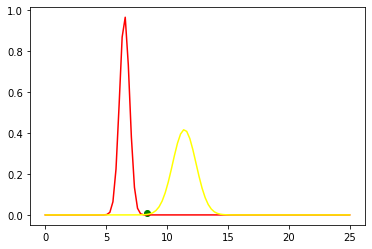

In [113]:
%matplotlib inline
import matplotlib.pyplot as plt

x = np.linspace(0, 25, 100)

yn = norm.pdf(x, meanSaumon, stdSaumon)
plt.plot(x, yn, c="red")

yn = norm.pdf(x, meanBar, stdBar)
plt.plot(x, yn, c="yellow")

plt.scatter(8.35, norm.pdf(8.7, meanBar, stdBar), c="green")

In [114]:

width = 12
if norm.pdf(width, meanSaumon, stdSaumon) > norm.pdf(width, meanBar, stdBar) :
  print("Saumon")
else:
  print("Bar")

Bar


Un poisson de longueur 12 est toujours un bar

In [115]:
print("Efficiency for width")
Y_pred = [norm.pdf(x, meanSaumon, stdSaumon) < norm.pdf(x, meanBar, stdBar) for x in X_test["width"]]

cm = confusion_matrix(Y_test, Y_pred)
print(cm)
acc = np.sum(np.diag(cm))/np.sum(cm)

print("{:.2%}".format(acc))

print("\n")

print("Efficiency for lightness")
Y_pred = [norm.pdf(x, meanSaumon, stdSaumon) < norm.pdf(x, meanBar, stdBar) for x in X_test["lightness"]]

cm = confusion_matrix(Y_test, Y_pred)
print(cm)
acc = np.sum(np.diag(cm))/np.sum(cm)

print("{:.2%}".format(acc))

Efficiency for width
[[ 98 106]
 [  1  95]]
64.33%


Efficiency for lightness
[[157  47]
 [ 19  77]]
78.00%


### Classifieur MAP

In [116]:
from sklearn.metrics import confusion_matrix

print("Efficiency for lightness")
Y_pred = [classify(np.mean(x)) for x in X["lightness"]]

cm = confusion_matrix(Y, Y_pred)
print(cm)
acc = np.sum(np.diag(cm))/np.sum(cm)

print("{:.2%}".format(acc))

print("\n")

print("Efficiency both")
Y_pred = [classify(np.mean(x)) for x in np.mean(X, axis=1)]

cm = confusion_matrix(Y, Y_pred)
print(cm)
acc = np.sum(np.diag(cm))/np.sum(cm)

print("{:.2%}".format(acc))

Efficiency for lightness
[[875 125]
 [ 93 407]]
85.47%


Efficiency both
[[743 257]
 [ 10 490]]
82.20%


## Exercice 3

In [117]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train.values, Y_train.values)

GaussianNB()

In [118]:
Y_pred = nb.predict(X_test.values)

cm = confusion_matrix(Y_test, Y_pred)
print(cm)
acc = np.sum(np.diag(cm))/np.sum(cm)

print("{:.2%}".format(acc))

[[203   1]
 [  5  91]]
98.00%


In [119]:
predF = nb.predict([[1.81, 59]])

if predF[0]:
  print("Bar")
else:
  print("Saumon")

Bar
